# PyGIMLi - Electrical Resistivity Tomography

Using the ERT solver implemented provided by [PyGIMLi](https://www.pygimli.org/), 
we use different `cofi` solvers to solve the corresponding inverse problem.

<!--<badge>--><a href="https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/notebooks/pygimli_ert/pygimli_ert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/environment.yml) file
specifies a list of packages required to run the notebooks)

## 0. Import modules

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi

# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !mamba install -c gimli pygimli=1.3

# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/notebooks/pygimli_ert

We will need the following packages:

- `numpy` for matrices and matrix-related functions
- `matplotlib` for plotting
- `pygimli` for forward modelling of the problem
- `cofi` for accessing different inference solvers

Additionally, we wrap some `pygimli` code in file `pygimli_ert_lib.py` and import it
here for conciseness.

In [2]:
import numpy as np
import pygimli
from pygimli.physics import ert

from cofi import BaseProblem, InversionOptions, Inversion
from cofi.solvers import BaseSolver

from pygimli_ert_lib import *

np.random.seed(42)

## 1. Define the problem

We first define the true model, the survey and map it on a computational mesh designed for the survey and true anomaly.

Text(0.5, 1.0, 'True model')

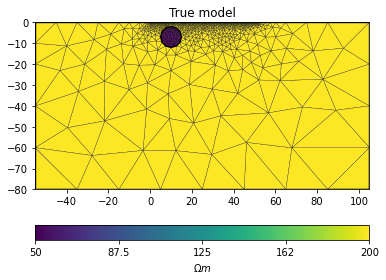

In [3]:
# PyGIMLi - define measuring scheme, geometry, forward mesh and true model
scheme = survey_scheme()
mesh, rhomap = model_true(scheme)

# plot the true model
ax = pygimli.show(mesh, data=rhomap, label="$\Omega m$", showMesh=True)
ax[0].set_title("True model")

Generate the synthetic data as a container with all the necessary information for plotting.

In ERT problems, the model and data are by convention treated in log space. 

03/08/22 - 11:28:11 - pyGIMLi - INFO - Calculate geometric factors.


ModellingBase::setMesh() copying new mesh ... Found datafile: 51 electrodes
Found: 51 free-electrodes
rMin = 0.5, rMax = 100
NGauLeg + NGauLag for inverse Fouriertransformation: 13 + 4
Found non-Neumann domain
0.013 s
FOP updating mesh dependencies ... 0 s
Obtaining geometric factors (analytical)
relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Data error estimate (min:max)  0.010009229451098493 : 0.22552739004919173
Calculating response for model: min = 50 max = 200
Allocating memory for primary potential...... 0.004

No primary potential for secondary field calculation. Calculating analytically...
Factorize (Cholmod) matrix ... 0.005
Factorize (Cholmod) matrix ... 0.004
Factorize (Cholmod) matrix ... 0.004
Factorize (Cholmod) matrix ... 0.005
Factorize (Cholmod) matrix ... 0.004
Factorize (Cholmod) matrix ... 0.004
Factorize (Cholmod) matrix ... 0.005
Factorize (Cholmod) matrix ... 0.004
Factorize (Cholmod) matrix ... 0.004
Factoriz

Text(0.5, 1.0, 'Provided data')

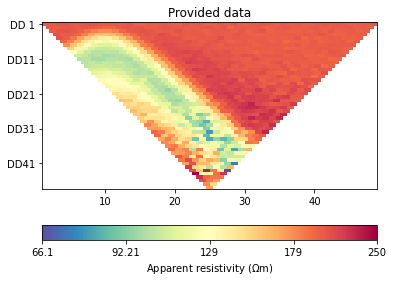

In [4]:
# PyGIMLi - generate data
data, log_data, data_cov_inv = ert_simulate(mesh, scheme, rhomap)

ax = ert.show(data)
ax[0].set_title("Provided data")

Further, we create a `pygimli.ert.ERTManager` instance to keep record of problem-specific
information like the inversion mesh, and to perform forward operation for the inversion
solvers.

In [5]:
# create PyGIMLi's ERT manager
ert_manager = ert_manager(data)

The inversion can use a different mesh and the mesh to be used should know nothing about the mesh that was designed based on the true model. We wrap two kinds of mesh as examples in the library code `pygimli_ert_lib.py`, namely triangular and rectangular mesh.

Use `imesh_tri = inversion_mesh(scheme)` to initialise a triangular mesh. This function uses PyGIMLi's own mesh generator
and generates triangular mesh automatically from given sensor locations. The resulting mesh will have a smaller area as 
unknowns to be inverted, as well as a background part with values prolongated outside from the parametric domain by PyGIMLi.
You will see an example plot in the code cell below. 

Use `imesh_rect = inversion_mesh_rect(ert_manager)` to initislise a rectangular mesh. The grid mesh is created from these x and y
nodes: `x = np.linspace(start=-5, stop=55, num=61)`, and `y = np.linspace(start=-20,stop=0,num=10)`. And again, there's a triangular
background with values prolongated outside from the parametric domain by PyGIMLi.

Here we first demonstrate how to use a *triangular mesh*. Note that this makes the inversion problem under-determined.

03/08/22 - 11:28:12 - pyGIMLi - INFO - Found 2 regions.


03/08/22 - 11:28:12 - pyGIMLi - INFO - Region with smallest marker (1) set to background


Text(0.5, 1.0, 'Mesh used for inversion')

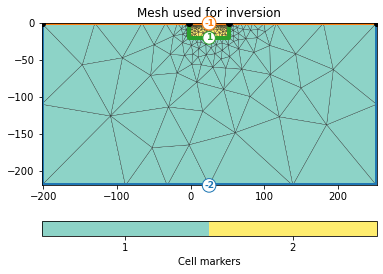

In [6]:
inv_mesh = inversion_mesh(ert_manager)
ax = pygimli.show(inv_mesh, showMesh=True, markers=True)
ax[0].set_title("Mesh used for inversion")

[This folder](https://github.com/inlab-geo/cofi-examples/tree/main/notebooks/pygimli_ert)
contains examples scripts that run inversion for triangular or rectangular meshes, with 
different inversion approaches.

With the inversion mesh created, we now define a starting model, forward operator and 
weighting matrix for regularisation using PyGIMLi.

Recall that both our model and data will be in log space when we perform inversion.

03/08/22 - 11:28:12 - Core - WARNING - Region Nr: 1  is background and should not get a model transformation.


03/08/22 - 11:28:12 - Core - WARNING - Region Nr: 1  is background and should not get a model control.


03/08/22 - 11:28:12 - pyGIMLi - INFO - Creating forward mesh from region infos.


03/08/22 - 11:28:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Text(0.5, 1.0, 'Starting model')

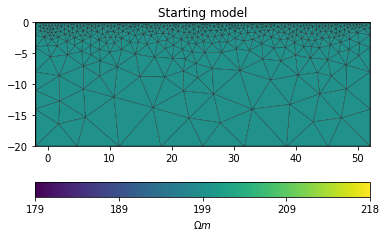

In [7]:
# PyGIMLi's forward operator (ERTModelling)
forward_oprt = ert_forward_operator(ert_manager, scheme, inv_mesh)

# extract regularisation matrix
Wm = reg_matrix(forward_oprt)

# initialise a starting model for inversion
start_model, start_model_log = starting_model(ert_manager)
ax = pygimli.show(ert_manager.paraDomain, data=start_model, label="$\Omega m$", showMesh=True)
ax[0].set_title("Starting model")

CoFI and other inference packages require a set of functions that provide the misfit, the jacobian the residual within the case of scipy standardised interfaces. All these functions are defined in the library file `pygimli_ert_lib.py`, so open this file if you'd like to find out the details. These functions are:

- `get_response`
- `get_jacobian`
- `get_residuals`
- `get_data_misfit`
- `get_regularisation`
- `get_gradient`
- `get_hessian`

With all the above forward operations set up with PyGIMLi, we now define the problem in `cofi`
by setting the problem information for a `BaseProblem` object.

In [8]:
# hyperparameters
lamda = 0.0001

# CoFI - define BaseProblem
ert_problem = BaseProblem()
ert_problem.name = "Electrical Resistivity Tomography defined through PyGIMLi"
ert_problem.set_forward(get_response, args=[forward_oprt])
ert_problem.set_jacobian(get_jacobian, args=[forward_oprt])
ert_problem.set_residual(get_residual, args=[log_data, forward_oprt])
ert_problem.set_data_misfit(get_data_misfit, args=[log_data, forward_oprt, data_cov_inv])
ert_problem.set_regularisation(get_regularisation, args=[Wm, lamda])
ert_problem.set_gradient(get_gradient, args=[log_data, forward_oprt, Wm, lamda, data_cov_inv])
ert_problem.set_hessian(get_hessian, args=[log_data, forward_oprt, Wm, lamda, data_cov_inv])
ert_problem.set_initial_model(start_model_log)

Review what information is included in the `BaseProblem` object:

In [9]:
ert_problem.summary()

Summary for inversion problem: Electrical Resistivity Tomography defined through PyGIMLi
Model shape: (831,)
----------------------------------------------------------------------------------------
List of functions/properties set by you:
['gradient', 'hessian', 'residual', 'jacobian', 'data_misfit', 'regularisation', 'forward', 'initial_model', 'model_shape']
----------------------------------------------------------------------------------------
List of functions/properties created based on what you have provided:
['objective', 'hessian_times_vector', 'jacobian_times_vector']
----------------------------------------------------------------------------------------
List of functions/properties not set by you:
['objective', 'log_posterior', 'log_posterior_with_blobs', 'log_likelihood', 'log_prior', 'hessian_times_vector', 'jacobian_times_vector', 'data', 'data_covariance', 'data_covariance_inv', 'walkers_starting_pos', 'blobs_dtype', 'bounds', 'constraints']


## 2. Define the inversion options and run

### 2.1 SciPy's optimiser ([trust-exact](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-trustexact.html#optimize-minimize-trustexact))

In [10]:
ert_problem.suggest_solvers();

Based on what you've provided so far, here are possible solvers:
{
    "optimisation": [
        "scipy.optimize.minimize",
        "scipy.optimize.least_squares"
    ],
    "linear least square": [],
    "sampling": []
}


In [11]:
inv_options_scipy = InversionOptions()
inv_options_scipy.set_tool("scipy.optimize.minimize")
inv_options_scipy.set_params(method="trust-exact")

Review what's been defined for the inversion we are about to run:

In [12]:
inv_options_scipy.summary()

Summary for inversion options
Solving method: None set
Use `suggest_solving_methods()` to check available solving methods.
-----------------------------
Backend tool: `scipy.optimize.minimize` - SciPy's optimisers that minimises a scalar function with respect to one or more variables, check SciPy's documentation page for a list of methods
References: ['https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html']
Use `suggest_tools()` to check available backend tools.
-----------------------------
Solver-specific parameters: 
method = trust-exact
Use `suggest_solver_params()` to check required/optional solver-specific parameters.


In [13]:
inv = Inversion(ert_problem, inv_options_scipy)
inv_result = inv.run()
inv_result.summary()

/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.10/site-packages/scipy/optimize/_minimize.py:554: RuntimeWarning: Method trust-exact does not use Hessian-vector product information (hessp).
  warn('Method %s does not use Hessian-vector product '


Summary for inversion result
FAILURE
----------------------------
status: 2
fun: 4.96015090789872
jac: [-5.30054030e-06  3.78314335e-06 -8.55026934e-06 -9.36818136e-07
 -1.97060620e-07 -6.83888997e-06 -4.07168948e-05 -8.86978491e-07
 -2.88829372e-06  2.07324889e-05  1.19916951e-05 -2.80271730e-06
 -9.46662352e-07 -4.41893669e-06 -1.77941068e-07 -1.21036666e-05
 -1.46466549e-06  5.25255026e-06  8.72728744e-06 -1.99888148e-06
 -2.38885420e-05  4.40875838e-06  2.37748338e-06  1.86784997e-05
 -2.80190922e-05  4.64603979e-06 -8.82350862e-06 -1.04835461e-05
 -4.90634932e-06 -1.37441127e-05 -8.05035313e-07  7.45791259e-06
  1.92902027e-05  9.25224850e-06 -8.21727771e-06  2.96294814e-06
 -2.70764010e-06  3.29374158e-06 -3.97521065e-06  4.37567474e-06
 -2.20569328e-06  4.47264496e-06  9.24191208e-06 -3.07899998e-06
  2.07688756e-06  7.09574929e-07  5.50356101e-06 -6.27742470e-06
  1.79641014e-06 -7.92319465e-06 -4.68692840e-06  7.75033889e-06
  1.56255821e-05  2.67002634e-06 -3.50604816e-06  5.

In [14]:
inv_result.success

False

Plot the results:

Summary for inversion result
FAILURE
----------------------------
status: 2
fun: 4.96015090789872
jac: [-5.30054030e-06  3.78314335e-06 -8.55026934e-06 -9.36818136e-07
 -1.97060620e-07 -6.83888997e-06 -4.07168948e-05 -8.86978491e-07
 -2.88829372e-06  2.07324889e-05  1.19916951e-05 -2.80271730e-06
 -9.46662352e-07 -4.41893669e-06 -1.77941068e-07 -1.21036666e-05
 -1.46466549e-06  5.25255026e-06  8.72728744e-06 -1.99888148e-06
 -2.38885420e-05  4.40875838e-06  2.37748338e-06  1.86784997e-05
 -2.80190922e-05  4.64603979e-06 -8.82350862e-06 -1.04835461e-05
 -4.90634932e-06 -1.37441127e-05 -8.05035313e-07  7.45791259e-06
  1.92902027e-05  9.25224850e-06 -8.21727771e-06  2.96294814e-06
 -2.70764010e-06  3.29374158e-06 -3.97521065e-06  4.37567474e-06
 -2.20569328e-06  4.47264496e-06  9.24191208e-06 -3.07899998e-06
  2.07688756e-06  7.09574929e-07  5.50356101e-06 -6.27742470e-06
  1.79641014e-06 -7.92319465e-06 -4.68692840e-06  7.75033889e-06
  1.56255821e-05  2.67002634e-06 -3.50604816e-06  5.

Text(0.5, 1.0, 'Inferred model')

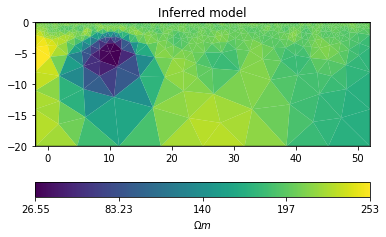

In [15]:
# convert back to normal space from log space
model = np.exp(inv_result.model)

# plot inferred model
inv_result.summary()
ax = pygimli.show(ert_manager.paraDomain, data=model, label=r"$\Omega m$")
ax[0].set_title("Inferred model")

Text(0.5, 1.0, 'Synthetic data from inferred model')

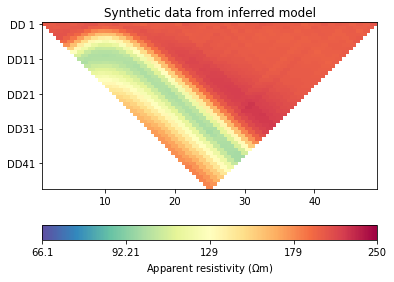

In [16]:
# plot synthetic data
d = forward_oprt.response(model)
ax = ert.showERTData(scheme, vals=d, cMin=np.min(data["rhoa"]), cMax=np.max(data["rhoa"]))
ax[0].set_title("Synthetic data from inferred model")

### 2.2 A custom [Newton's optimisation](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization) approach

Now we switch to a Newton's iterative approach written by ourselves, so you'll 
have a closer look at what's happening in the loop.

First of all, define our own solver.

In [17]:
class GaussNewton(BaseSolver):
    def __init__(self, inv_problem, inv_options):
        __params = inv_options.get_params()
        self._niter = __params.get("niter", 100)
        self._verbose = __params.get("verbose", True)
        self._step = __params.get("step", 1)
        self._model_0 = inv_problem.initial_model
        self._residual = inv_problem.residual
        self._jacobian = inv_problem.jacobian
        self._gradient = inv_problem.gradient
        self._hessian = inv_problem.hessian
        self._misfit = inv_problem.data_misfit if inv_problem.data_misfit_defined else None
        self._reg = inv_problem.regularisation if inv_problem.regularisation_defined else None
        self._obj = inv_problem.objective if inv_problem.objective_defined else None

    def __call__(self):
        current_model = np.array(self._model_0)
        for i in range(self._niter):
            if self._verbose:
                print("-" * 80)
                print(f"Iteration {i+1}")
                print("model min and max:", np.min(current_model), np.max(current_model))
                if self._misfit: print("data misfit:", self._misfit(current_model))
                if self._reg: print("regularisation:", self._reg(current_model))
            term1 = self._hessian(current_model)
            term2 = - self._gradient(current_model)
            model_update = np.linalg.solve(term1, term2) * self._step
            current_model = current_model + model_update
        return {"model": current_model, "success": True}

Now, make use of this custom solver and run inversion again:

In [18]:
# hyperparameters
lamda = 0.0001
niter = 150
inv_verbose = True
step = 0.005

# CoFI - define InversionOptions
inv_options = InversionOptions()
inv_options.set_tool(GaussNewton)
inv_options.set_params(niter=niter, verbose=inv_verbose, step=step)

# CoFI - define Inversion, run it
inv = Inversion(ert_problem, inv_options)
inv_result = inv.run()

--------------------------------------------------------------------------------
Iteration 1
model min and max: 5.291310843489913 5.291310843489913
data misfit: 229.71418345445022
regularisation: 0.0


--------------------------------------------------------------------------------
Iteration 2
model min and max: 5.275884701683029 5.304449604934593
data misfit: 227.23411332788962
regularisation: 0.010102187048030783


--------------------------------------------------------------------------------
Iteration 3
model min and max: 5.262031885900456 5.310706445059947
data misfit: 224.88018892913274
regularisation: 0.023828812726623613


--------------------------------------------------------------------------------
Iteration 4
model min and max: 5.248398551565956 5.315148641785338
data misfit: 222.5841638420562
regularisation: 0.03833074053511782


--------------------------------------------------------------------------------
Iteration 5
model min and max: 5.235210460904474 5.318970381280445
data misfit: 220.32501943579953
regularisation: 0.05346144871876975


--------------------------------------------------------------------------------
Iteration 6
model min and max: 5.221988655748717 5.322505463476199
data misfit: 218.09539040624733
regularisation: 0.06913735737874388


--------------------------------------------------------------------------------
Iteration 7
model min and max: 5.208735295257404 5.325860648352957
data misfit: 215.892125425656
regularisation: 0.08529292762625605


--------------------------------------------------------------------------------
Iteration 8
model min and max: 5.195697353190847 5.329074034023867
data misfit: 213.71361019906533
regularisation: 0.10188094041714764


--------------------------------------------------------------------------------
Iteration 9
model min and max: 5.182852523974191 5.332161355802607


data misfit: 211.5588753156785
regularisation: 0.1188669895241025


--------------------------------------------------------------------------------
Iteration 10
model min and max: 5.170183680331992 5.335368509287406
data misfit: 209.4272561757092
regularisation: 0.136224060259363


--------------------------------------------------------------------------------
Iteration 11
model min and max: 5.157677506123857 5.338687354756616
data misfit: 207.3182453718031
regularisation: 0.15392888174445676


--------------------------------------------------------------------------------
Iteration 12
model min and max: 5.145323421153337 5.341863067682297
data misfit: 205.23142386946935
regularisation: 0.1719597770425735


--------------------------------------------------------------------------------
Iteration 13
model min and max: 5.133112822085423 5.344904921854035


data misfit: 203.16642492615006
regularisation: 0.19029556215911583


--------------------------------------------------------------------------------
Iteration 14
model min and max: 5.121038565645402 5.347822179938559
data misfit: 201.12291605687238
regularisation: 0.2089150526014612


--------------------------------------------------------------------------------
Iteration 15
model min and max: 5.109094612573696 5.350623899377063
data misfit: 199.1005873204019
regularisation: 0.22779693654114716


--------------------------------------------------------------------------------
Iteration 16
model min and max: 5.097275776224142 5.353318771427106
data misfit: 197.09914546356381
regularisation: 0.24691982779218852


--------------------------------------------------------------------------------
Iteration 17
model min and max: 5.085577543218312 5.355915037499392
data misfit: 195.1183106780502
regularisation: 0.2662624014293795


--------------------------------------------------------------------------------
Iteration 18
model min and max: 5.073995942552032 5.358420418108902
data misfit: 193.15781346330175
regularisation: 0.28580356014372404


--------------------------------------------------------------------------------
Iteration 19
model min and max: 5.062527443233031 5.360842098918295
data misfit: 191.21739387575644
regularisation: 0.30552259718444025


--------------------------------------------------------------------------------
Iteration 20
model min and max: 5.051168876563746 5.363186710295556
data misfit: 189.29679965235673
regularisation: 0.32539933587795333


--------------------------------------------------------------------------------
Iteration 21
model min and max: 5.039917379336293 5.36546036416221
data misfit: 187.3957862579242
regularisation: 0.34541424596735104


--------------------------------------------------------------------------------
Iteration 22
model min and max: 5.028770340585007 5.367668656123106


data misfit: 185.514115785678
regularisation: 0.36554853574010154


--------------------------------------------------------------------------------
Iteration 23
model min and max: 5.0177253682819005 5.369816711223571


data misfit: 183.65155678774858
regularisation: 0.3857842100851556


--------------------------------------------------------------------------------
Iteration 24
model min and max: 5.006780251445219 5.371909207553527


data misfit: 181.80788344019362
regularisation: 0.4061041302249163


--------------------------------------------------------------------------------
Iteration 25
model min and max: 4.995932941294416 5.373950416865355
data misfit: 179.9828755687684
regularisation: 0.4264920217827422


--------------------------------------------------------------------------------
Iteration 26
model min and max: 4.98518152546452 5.375944233954601
data misfit: 178.17631801144034
regularisation: 0.4469324995229744


--------------------------------------------------------------------------------
Iteration 27
model min and max: 4.974524211269277 5.377894212824454
data misfit: 176.3880007794431
regularisation: 0.4674110546507778


--------------------------------------------------------------------------------
Iteration 28
model min and max: 4.963959312536254 5.379803593410636
data misfit: 174.61771808953412
regularisation: 0.48791404822093465


--------------------------------------------------------------------------------
Iteration 29
model min and max: 4.953485236088046 5.381675329745428
data misfit: 172.8652685564188
regularisation: 0.5084287005326397


--------------------------------------------------------------------------------
Iteration 30
model min and max: 4.943100471064561 5.383512120043909
data misfit: 171.13045503046692
regularisation: 0.5289430509051922


--------------------------------------------------------------------------------
Iteration 31
model min and max: 4.93280358190384 5.385316428689782
data misfit: 169.41308383642195
regularisation: 0.549445945725652


--------------------------------------------------------------------------------
Iteration 32
model min and max: 4.922593199750961 5.387090509277843
data misfit: 167.71296524705306
regularisation: 0.5699269969758057


--------------------------------------------------------------------------------
Iteration 33
model min and max: 4.912468014404413 5.388836423101432
data misfit: 166.02991298112045
regularisation: 0.5903765548595631


--------------------------------------------------------------------------------
Iteration 34
model min and max: 4.9024267715561605 5.390556051427799
data misfit: 164.36374380365098
regularisation: 0.6107856710414185


--------------------------------------------------------------------------------
Iteration 35
model min and max: 4.892468266762785 5.392251128493523
data misfit: 162.71427750170972
regularisation: 0.6311460715482108


--------------------------------------------------------------------------------
Iteration 36
model min and max: 4.88259134130077 5.39392323814174
data misfit: 161.0813373059921
regularisation: 0.6514501101998089


--------------------------------------------------------------------------------
Iteration 37
model min and max: 4.872794877802661 5.395573836382838
data misfit: 159.46474886077266
regularisation: 0.6716907506288601


--------------------------------------------------------------------------------
Iteration 38
model min and max: 4.8630777992324905 5.397204260308721
data misfit: 157.86434051758454
regularisation: 0.6918615228982422


--------------------------------------------------------------------------------
Iteration 39
model min and max: 4.8534390629814865 5.398815737635267
data misfit: 156.27994362813175
regularisation: 0.711956489525659


--------------------------------------------------------------------------------
Iteration 40
model min and max: 4.843877660540191 5.400409404939352
data misfit: 154.7113914392031
regularisation: 0.731970231994938


--------------------------------------------------------------------------------
Iteration 41
model min and max: 4.834392614595705 5.401986306121495


data misfit: 153.1585200053411
regularisation: 0.7518977962230643


--------------------------------------------------------------------------------
Iteration 42
model min and max: 4.8249829769857175 5.403547402018953
data misfit: 151.62116734960452
regularisation: 0.7717346840165353


--------------------------------------------------------------------------------
Iteration 43
model min and max: 4.815647827351933 5.405093589755454
data misfit: 150.0991740404102
regularisation: 0.7914768181136892


--------------------------------------------------------------------------------
Iteration 44
model min and max: 4.806386269092894 5.4066256849168655
data misfit: 148.59238263640933
regularisation: 0.8111205127415686


--------------------------------------------------------------------------------
Iteration 45
model min and max: 4.797197431706862 5.408144449227498


data misfit: 147.10063776580617
regularisation: 0.8306624530390341


--------------------------------------------------------------------------------
Iteration 46
model min and max: 4.788080466379465 5.409650589188703
data misfit: 145.6237860243799
regularisation: 0.8500996723674525


--------------------------------------------------------------------------------
Iteration 47
model min and max: 4.779034546606689 5.411144754328156
data misfit: 144.1616760628408
regularisation: 0.8694295263532019


--------------------------------------------------------------------------------
Iteration 48
model min and max: 4.770058865171063 5.412627552213421


data misfit: 142.71415837624176
regularisation: 0.8886496780325105


--------------------------------------------------------------------------------
Iteration 49
model min and max: 4.761152634922138 5.414099547406628
data misfit: 141.28108507204146
regularisation: 0.9077580699504195


--------------------------------------------------------------------------------
Iteration 50
model min and max: 4.75231508632934 5.415561259847664


data misfit: 139.86231043937474
regularisation: 0.926752905479055


--------------------------------------------------------------------------------
Iteration 51
model min and max: 4.743545468725594 5.417013174830312
data misfit: 138.4576902451595
regularisation: 0.9456326378942388


--------------------------------------------------------------------------------
Iteration 52
model min and max: 4.734843045652074 5.418455745993275


data misfit: 137.0670820466871
regularisation: 0.9643959505537264


--------------------------------------------------------------------------------
Iteration 53
model min and max: 4.726207099023151 5.41988939840098
data misfit: 135.69034512639965
regularisation: 0.9830417403576432


--------------------------------------------------------------------------------
Iteration 54
model min and max: 4.7176369237811695 5.421314518650831
data misfit: 134.32734005793313
regularisation: 1.0015690966190833


--------------------------------------------------------------------------------
Iteration 55
model min and max: 4.709131830086482 5.422731475877443
data misfit: 132.9779295692208
regularisation: 1.019977289384316


--------------------------------------------------------------------------------
Iteration 56
model min and max: 4.700691142432957 5.424140613263493
data misfit: 131.64197733763353
regularisation: 1.0382657738396288


--------------------------------------------------------------------------------
Iteration 57
model min and max: 4.692314197253299 5.425542250596371
data misfit: 130.3193490218099
regularisation: 1.0564341506480102


--------------------------------------------------------------------------------
Iteration 58
model min and max: 4.684000345177091 5.426936687333739
data misfit: 129.0099116150112
regularisation: 1.0744821685381811


--------------------------------------------------------------------------------
Iteration 59
model min and max: 4.675748947098593 5.428324198050183
data misfit: 127.71353343911387
regularisation: 1.092409712077045


--------------------------------------------------------------------------------
Iteration 60
model min and max: 4.667559377076292 5.429705050722258
data misfit: 126.43008461789586
regularisation: 1.1102167898720323


--------------------------------------------------------------------------------
Iteration 61
model min and max: 4.659431019632232 5.431079485200306


data misfit: 125.15943610782304
regularisation: 1.1279035252470482


--------------------------------------------------------------------------------
Iteration 62
model min and max: 4.651363270487282 5.432447733344564


data misfit: 123.9014608855537
regularisation: 1.1454701438210855


--------------------------------------------------------------------------------
Iteration 63
model min and max: 4.643355536126746 5.433810014739541


data misfit: 122.6560328783673
regularisation: 1.1629169744634125


--------------------------------------------------------------------------------
Iteration 64
model min and max: 4.635407231730798 5.435166525302718


data misfit: 121.42302740113477
regularisation: 1.1802444273250605


--------------------------------------------------------------------------------
Iteration 65
model min and max: 4.627517783787344 5.436517458870142


data misfit: 120.20232132669521
regularisation: 1.197452999295425


--------------------------------------------------------------------------------
Iteration 66
model min and max: 4.619686626871865 5.437862988272354
data misfit: 118.99379251676498
regularisation: 1.214543255880672


--------------------------------------------------------------------------------
Iteration 67
model min and max: 4.611913205864353 5.4392032858955135
data misfit: 117.79732043902516
regularisation: 1.2315158348701343


--------------------------------------------------------------------------------
Iteration 68
model min and max: 4.604196972835669 5.440538507748801
data misfit: 116.61278550186493
regularisation: 1.2483714297346002


--------------------------------------------------------------------------------
Iteration 69
model min and max: 4.596537389260285 5.4418687987733545
data misfit: 115.4400695986893
regularisation: 1.2651107953672196


--------------------------------------------------------------------------------
Iteration 70
model min and max: 4.588933924906156 5.443194305165944
data misfit: 114.27905560311517
regularisation: 1.2817347331348665


--------------------------------------------------------------------------------
Iteration 71
model min and max: 4.581386057254488 5.444515152952376
data misfit: 113.12962777685908
regularisation: 1.298244085276774


--------------------------------------------------------------------------------
Iteration 72
model min and max: 4.573893271416084 5.44583146211928
data misfit: 111.99167167496597
regularisation: 1.3146397419452676


--------------------------------------------------------------------------------
Iteration 73
model min and max: 4.566455060606431 5.4471433555344255
data misfit: 110.86507371041692
regularisation: 1.3309226237620941


--------------------------------------------------------------------------------
Iteration 74
model min and max: 4.559070924814049 5.448450941266657
data misfit: 109.74972168905651
regularisation: 1.3470936855316664


--------------------------------------------------------------------------------
Iteration 75
model min and max: 4.55174037018639 5.449754315220033
data misfit: 108.64550462298934
regularisation: 1.363153905968212


--------------------------------------------------------------------------------
Iteration 76
model min and max: 4.544462910908656 5.451053583548627


data misfit: 107.552312402364
regularisation: 1.3791042909413382


--------------------------------------------------------------------------------
Iteration 77
model min and max: 4.537238068038489 5.4523488337179264


data misfit: 106.47003619967165
regularisation: 1.3949458653084554


--------------------------------------------------------------------------------
Iteration 78
model min and max: 4.530065368473269 5.453640151825503
data misfit: 105.39856824158795
regularisation: 1.4106796758652547


--------------------------------------------------------------------------------
Iteration 79
model min and max: 4.522944345432405 5.45492761925637


data misfit: 104.33780180995225
regularisation: 1.426306778091754


--------------------------------------------------------------------------------
Iteration 80
model min and max: 4.515874537846262 5.456211310989019
data misfit: 103.28763128559409
regularisation: 1.4418282400956361


--------------------------------------------------------------------------------
Iteration 81
model min and max: 4.508855493277836 5.4574913008510055
data misfit: 102.24795227460508
regularisation: 1.4572451454540025


--------------------------------------------------------------------------------
Iteration 82
model min and max: 4.5018867618866265 5.458767657979288
data misfit: 101.21866112882363
regularisation: 1.4725585816280777


--------------------------------------------------------------------------------
Iteration 83
model min and max: 4.494967901324927 5.460040446676562
data misfit: 100.19965538774181
regularisation: 1.487769641296455


--------------------------------------------------------------------------------
Iteration 84
model min and max: 4.488098473709433 5.461309723129104
data misfit: 99.19083378846334
regularisation: 1.502879418799793


--------------------------------------------------------------------------------
Iteration 85
model min and max: 4.481278048436665 5.462575547454249
data misfit: 98.19209570727085
regularisation: 1.5178890100610964


--------------------------------------------------------------------------------
Iteration 86
model min and max: 4.474506198991838 5.463837975815357
data misfit: 97.20334176265787
regularisation: 1.5327995203102585


--------------------------------------------------------------------------------
Iteration 87
model min and max: 4.4677825041370935 5.465097054745742


data misfit: 96.22447356239108
regularisation: 1.5476120398919828


--------------------------------------------------------------------------------
Iteration 88
model min and max: 4.461106547434834 5.466352832174609


data misfit: 95.25539353083248
regularisation: 1.562327660692748


--------------------------------------------------------------------------------
Iteration 89
model min and max: 4.454477917857632 5.467605355817877
data misfit: 94.29600528769339
regularisation: 1.5769474770549092


--------------------------------------------------------------------------------
Iteration 90
model min and max: 4.447896209603077 5.468854667025775
data misfit: 93.34621325777489
regularisation: 1.5914725697386676


--------------------------------------------------------------------------------
Iteration 91
model min and max: 4.441361021259652 5.470100804742431


data misfit: 92.40592294458668
regularisation: 1.6059040139261433


--------------------------------------------------------------------------------
Iteration 92
model min and max: 4.434871956850117 5.47134380799953


data misfit: 91.47504046287139
regularisation: 1.6202428834751053


--------------------------------------------------------------------------------
Iteration 93
model min and max: 4.428428622783078 5.472583708974498
data misfit: 90.55347314896551
regularisation: 1.6344902333550362


--------------------------------------------------------------------------------
Iteration 94
model min and max: 4.422030632875815 5.473820544586524
data misfit: 89.64112924285119
regularisation: 1.6486471175998978


--------------------------------------------------------------------------------
Iteration 95
model min and max: 4.4156776037770955 5.475054345659011
data misfit: 88.73791789694803
regularisation: 1.662714583579255


--------------------------------------------------------------------------------
Iteration 96
model min and max: 4.409369156146104 5.476285137002959


data misfit: 87.8437488099508
regularisation: 1.6766936565891521


--------------------------------------------------------------------------------
Iteration 97
model min and max: 4.403104916160273 5.4775129502914055
data misfit: 86.95853313942787
regularisation: 1.690585358554243


--------------------------------------------------------------------------------
Iteration 98
model min and max: 4.3968845135536085 5.478737814008266


data misfit: 86.08218249025636
regularisation: 1.7043907022647762


--------------------------------------------------------------------------------
Iteration 99
model min and max: 4.390707580985061 5.479959743123045
data misfit: 85.21460937810053
regularisation: 1.7181106804130029


--------------------------------------------------------------------------------
Iteration 100
model min and max: 4.384573757297292 5.481178772929109
data misfit: 84.35572743571649
regularisation: 1.7317462762703133


--------------------------------------------------------------------------------
Iteration 101
model min and max: 4.37848268385436 5.482394915548821
data misfit: 83.50545076867694
regularisation: 1.745298467573676


--------------------------------------------------------------------------------
Iteration 102
model min and max: 4.372434005716354 5.483608192047444


data misfit: 82.66369488589048
regularisation: 1.7587682050250963


--------------------------------------------------------------------------------
Iteration 103
model min and max: 4.3664273729854015 5.484818622806393
data misfit: 81.83037531711092
regularisation: 1.7721564411122452


--------------------------------------------------------------------------------
Iteration 104
model min and max: 4.3604624388465725 5.486026226689867
data misfit: 81.00540905874284
regularisation: 1.785464102516996


--------------------------------------------------------------------------------
Iteration 105
model min and max: 4.354538859625091 5.487231017746508
data misfit: 80.18871373270579
regularisation: 1.7986921078609082


--------------------------------------------------------------------------------
Iteration 106
model min and max: 4.348656295552636 5.488433010950568
data misfit: 79.38020781913633
regularisation: 1.8118413588783315


--------------------------------------------------------------------------------
Iteration 107
model min and max: 4.342814410673755 5.48963222025286


data misfit: 78.5798104960511
regularisation: 1.824912749475322


--------------------------------------------------------------------------------
Iteration 108
model min and max: 4.337012873233878 5.4908286618218


data misfit: 77.78744159022179
regularisation: 1.8379071543210108


--------------------------------------------------------------------------------
Iteration 109
model min and max: 4.331251353230742 5.4920223422199665
data misfit: 77.0030221191503
regularisation: 1.850825434280101


--------------------------------------------------------------------------------
Iteration 110
model min and max: 4.325529525688633 5.493213276521564


data misfit: 76.2264735868664
regularisation: 1.8636684387108204


--------------------------------------------------------------------------------
Iteration 111
model min and max: 4.319847067337187 5.494401469769899
data misfit: 75.45771830630939
regularisation: 1.8764369944093557


--------------------------------------------------------------------------------
Iteration 112
model min and max: 4.314203660315035 5.4955869423712445


data misfit: 74.69667928818569
regularisation: 1.8891319271339653


--------------------------------------------------------------------------------
Iteration 113
model min and max: 4.30859898820094 5.496769691859941


data misfit: 73.94328042053512
regularisation: 1.9017540358131526


--------------------------------------------------------------------------------
Iteration 114
model min and max: 4.303032737927605 5.497949733301526
data misfit: 73.19744644654939
regularisation: 1.9143041161431658


--------------------------------------------------------------------------------
Iteration 115
model min and max: 4.297504599557081 5.499127067399089
data misfit: 72.45910234955997
regularisation: 1.926782942416276


--------------------------------------------------------------------------------
Iteration 116
model min and max: 4.292014268019181 5.500301706228015


data misfit: 71.72817455598765
regularisation: 1.939191277670208


--------------------------------------------------------------------------------
Iteration 117
model min and max: 4.286561438785408 5.501473654640578
data misfit: 71.00458935794461
regularisation: 1.9515298762867537


--------------------------------------------------------------------------------
Iteration 118
model min and max: 4.281145811894817 5.502642916647922
data misfit: 70.28827462611076
regularisation: 1.9637994606227944


--------------------------------------------------------------------------------
Iteration 119
model min and max: 4.275767090359645 5.503809497126526


data misfit: 69.57915840577007
regularisation: 1.9760007659430578


--------------------------------------------------------------------------------
Iteration 120
model min and max: 4.270424978969965 5.504973399530826


data misfit: 68.87716960268833
regularisation: 1.9881344921354926


--------------------------------------------------------------------------------
Iteration 121
model min and max: 4.2651191865614475 5.506134631528062


data misfit: 68.18223767683703
regularisation: 2.0002013392463978


--------------------------------------------------------------------------------
Iteration 122
model min and max: 4.25984942392132 5.5072931936050535
data misfit: 67.49429299120065
regularisation: 2.012201988883973


--------------------------------------------------------------------------------
Iteration 123
model min and max: 4.2546154043562 5.508449087675853
data misfit: 66.81326653857496
regularisation: 2.024137106210657


--------------------------------------------------------------------------------
Iteration 124
model min and max: 4.249416845887234 5.509602317765775
data misfit: 66.13908980773942
regularisation: 2.0360073573610276


--------------------------------------------------------------------------------
Iteration 125
model min and max: 4.244253467011841 5.510752883795492
data misfit: 65.47169512494415
regularisation: 2.047813376155628


--------------------------------------------------------------------------------
Iteration 126
model min and max: 4.239124990325411 5.5119007925906285
data misfit: 64.81101541904546
regularisation: 2.059555800897281


--------------------------------------------------------------------------------
Iteration 127
model min and max: 4.234031140032385 5.5130460385003754
data misfit: 64.15698425894404
regularisation: 2.071235243704614


--------------------------------------------------------------------------------
Iteration 128
model min and max: 4.228971644790381 5.514188629036911
data misfit: 63.509535874465485
regularisation: 2.0828523203301854


--------------------------------------------------------------------------------
Iteration 129
model min and max: 4.2239462333838285 5.515328559918047
data misfit: 62.86860523167743
regularisation: 2.0944076196111565


--------------------------------------------------------------------------------
Iteration 130
model min and max: 4.218954638860076 5.516465832728203
data misfit: 62.234127755812324
regularisation: 2.1059017327394796


--------------------------------------------------------------------------------
Iteration 131
model min and max: 4.21399659574795 5.517600445803593
data misfit: 61.60603968767108
regularisation: 2.1173352249867055


--------------------------------------------------------------------------------
Iteration 132
model min and max: 4.209071841078217 5.518732401348763
data misfit: 60.98427768830887
regularisation: 2.1287086581354147


--------------------------------------------------------------------------------
Iteration 133
model min and max: 4.204180115194253 5.519861698910708
data misfit: 60.36877905447835
regularisation: 2.140022590462575


--------------------------------------------------------------------------------
Iteration 134
model min and max: 4.199321161015461 5.520988338705297
data misfit: 59.75948186612955
regularisation: 2.151277555725498


--------------------------------------------------------------------------------
Iteration 135
model min and max: 4.194494723014814 5.522112320028225
data misfit: 59.15632473765349
regularisation: 2.162474084269752


--------------------------------------------------------------------------------
Iteration 136
model min and max: 4.189700547816759 5.5232336355790705
data misfit: 58.55924679785774
regularisation: 2.1736126944935505


--------------------------------------------------------------------------------
Iteration 137
model min and max: 4.184938385356865 5.524352289292718
data misfit: 57.96818782833384
regularisation: 2.1846938946078964


--------------------------------------------------------------------------------
Iteration 138
model min and max: 4.180207986352759 5.525468278971885
data misfit: 57.38308828504618
regularisation: 2.195718181254658


--------------------------------------------------------------------------------
Iteration 139
model min and max: 4.175509105049053 5.526581601570643


data misfit: 56.80388905611504
regularisation: 2.206686048239682


--------------------------------------------------------------------------------
Iteration 140
model min and max: 4.170841498338404 5.52769225921732
data misfit: 56.23053156802727
regularisation: 2.2175979719062013


--------------------------------------------------------------------------------
Iteration 141
model min and max: 4.166204924203444 5.528800244758935
data misfit: 55.662957911216104
regularisation: 2.228454425256324


--------------------------------------------------------------------------------
Iteration 142
model min and max: 4.161599143439426 5.529905557963576
data misfit: 55.101110884688204
regularisation: 2.2392558660554838


--------------------------------------------------------------------------------
Iteration 143
model min and max: 4.157023918143444 5.531008193306388
data misfit: 54.544933614354704
regularisation: 2.250002745297681


--------------------------------------------------------------------------------
Iteration 144
model min and max: 4.152479013762504 5.532108156184821


data misfit: 53.99436982441884
regularisation: 2.260695506414359


--------------------------------------------------------------------------------
Iteration 145
model min and max: 4.147964197685909 5.533205438010237
data misfit: 53.44936386452144
regularisation: 2.2713345889562095


--------------------------------------------------------------------------------
Iteration 146
model min and max: 4.143479238678478 5.534300038407142
data misfit: 52.909860673739665
regularisation: 2.2819204136048983


--------------------------------------------------------------------------------
Iteration 147
model min and max: 4.1390239073294905 5.535391954999352


data misfit: 52.37580550427834
regularisation: 2.292453398827582


--------------------------------------------------------------------------------
Iteration 148
model min and max: 4.134597977750466 5.536481183693961
data misfit: 51.84714429588892
regularisation: 2.302933959153743


--------------------------------------------------------------------------------
Iteration 149
model min and max: 4.130201224738901 5.53756772319681


data misfit: 51.323823633671815
regularisation: 2.313362491833923


--------------------------------------------------------------------------------
Iteration 150
model min and max: 4.125833426167237 5.538651572063103
data misfit: 50.805790300155685
regularisation: 2.323739399582284


Text(0.5, 1.0, 'Inferred model')

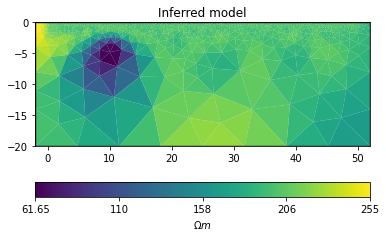

In [19]:
# convert from log space
model = np.exp(inv_result.model)

# plot inferred model
ax = pygimli.show(ert_manager.paraDomain, data=model, label=r"$\Omega m$")
ax[0].set_title("Inferred model")

Text(0.5, 1.0, 'Synthetic data from inferred model')

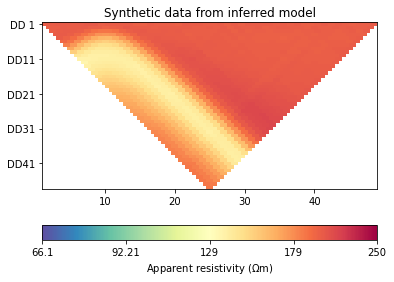

In [20]:
# plot synthetic data
d = forward_oprt.response(model)
ax = ert.showERTData(scheme, vals=d, cMin=np.min(data["rhoa"]), cMax=np.max(data["rhoa"]))
ax[0].set_title("Synthetic data from inferred model")

## 3. What's next?

Now that we've seen the PyGIMLi ERT problem solved by two different inversion approaches through CoFI,
it would be nice to see more inversion solvers (even a sampler!) and a similar problem
defined with a rectangular mesh. If you'd like to see some self-contained examples, head to
[this GitHub folder](https://github.com/inlab-geo/cofi-examples/tree/main/notebooks/pygimli_ert)
to explore more.

<!-- ### 2.3 Bayesian sampling with emcee (exploration)

CoFI needs more assumptions about the problem for a sampler to work - these are
the log of posterior distribution density and walkers' starting positions.

For the log posterior, we define here by specifying `log_prior` and `log_likelihood`.
And CoFI will combine them to get the `log_posterior`. -->

---
## Watermark

In [21]:
watermark_list = ["cofi", "numpy", "scipy", "pygimli", "matplotlib", "emcee", "arviz"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.1.2.dev8
numpy 1.21.6
scipy 1.8.1
pygimli 1.2.6
matplotlib 3.5.2
emcee 3.1.2
arviz 0.12.1
